## import libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle

# import clean text data
import re
import html
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import string
import unicodedata
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')



#Dat_preprocssing
from sklearn.model_selection import train_test_split
from datasets import Dataset

#model
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIROO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIROO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* Read dataset

In [4]:

df=pd.read_csv('text_summarizer_data.csv')
df.head()

,Unnamed: 0,title,content
0,0,Aegon Life iTerm plan helps you save tax & get...,Aegon Life iTerm insurance plan helps you save...
1,1,I'm no more an orphan: Woman finds 103-yr-old ...,An 81-year-old woman named Eileen Macken who g...
2,2,Bulls**t: Krish on Kangana's claim of directin...,'Manikarnika: The Queen of Jhansi' co-director...
3,3,Esha shares chat of friend calling footballer ...,Actress Esha Gupta has apologised on Twitter f...
4,4,"Pandya takes flying catch, 2 wickets on return...",All-rounder Hardik Pandya took a flying catch ...


## EDA

In [5]:
# to know shape of data
df.shape

(10510, 3)

In [6]:
#to see null or no
df.isnull().sum()

Unnamed: 0    0
title         0
content       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10510 entries, 0 to 10509
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10510 non-null  int64 
 1   title       10510 non-null  object
 2   content     10510 non-null  object
dtypes: int64(1), object(2)
memory usage: 246.5+ KB


In [8]:
#drop unnecessary column
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
#to know if there is duplicated or no
df.duplicated().sum()

12

In [10]:
# to drop duplicated
df.drop_duplicates(inplace=True)

In [11]:
#check again
df.duplicated().sum()

0

In [45]:
# to know number of characters in row 4

len(df['content'][4])

236

In [44]:
#for example to know number of tokenz in row 4

len(df['content'][4].split())

38

### `VIS`

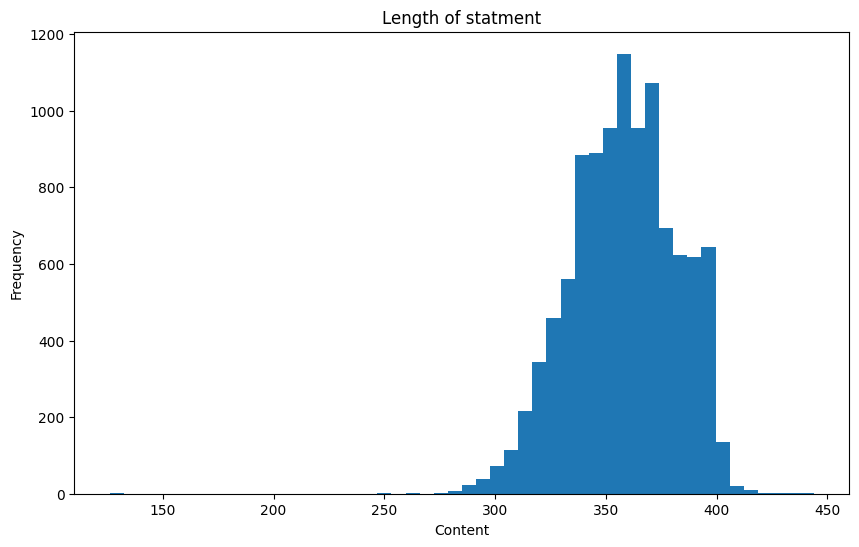

In [13]:
length_statment = df['content'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_statment, bins=50)
plt.title('Length of statment')
plt.xlabel('Content')
plt.ylabel('Frequency')
plt.show()

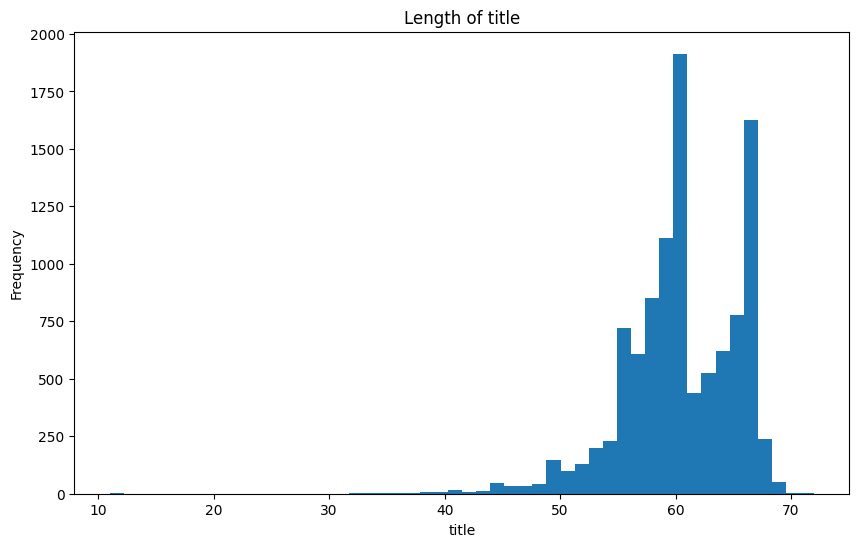

In [14]:
length_statment = df['title'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_statment, bins=50)
plt.title('Length of title')
plt.xlabel('title')
plt.ylabel('Frequency')
plt.show()

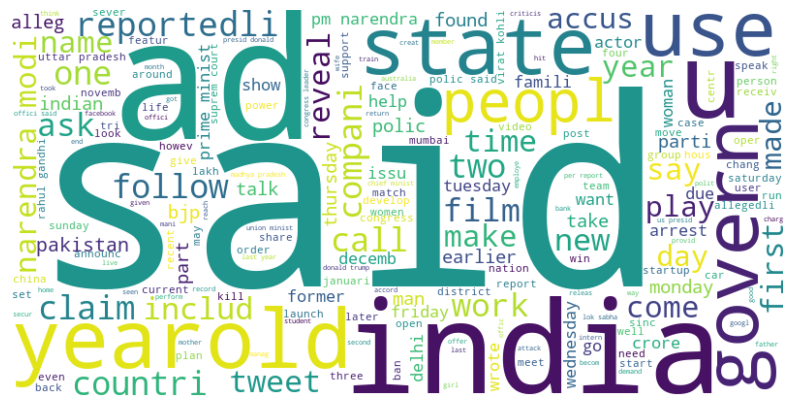

In [46]:
# merge all text in only text to create wordcloude
all_text = ' '.join(df['content'].astype(str))

#to see more repeat word in curpus
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

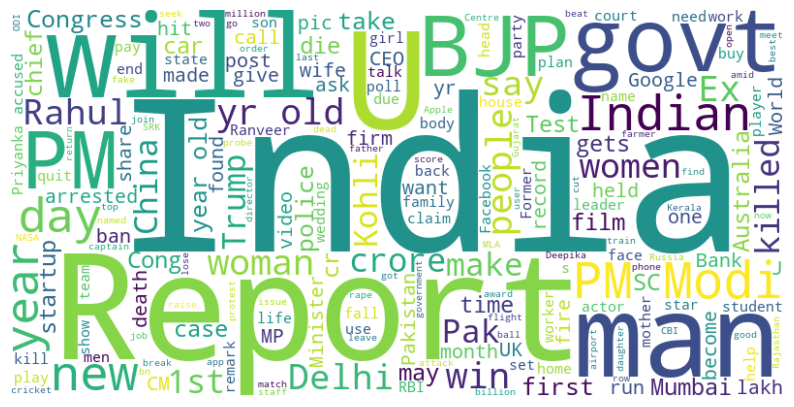

In [16]:
# merge all text in only text to create wordcloude
all_text = ' '.join(df['title'].astype(str))

#to see more repeat word in curpus
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

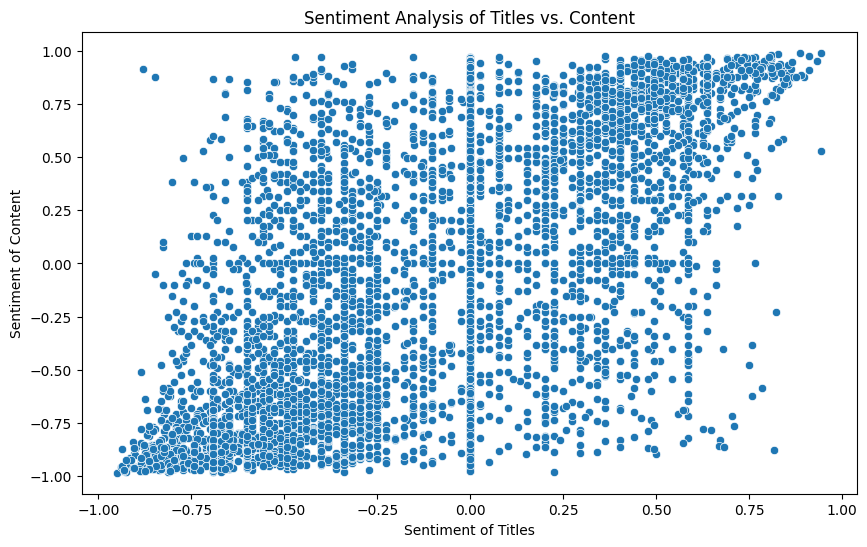

In [50]:

sid = SentimentIntensityAnalyzer()

# implement analysis on 'title','content'
df['sentiment_title'] = df['title'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_content'] = df['content'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Plotting by scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['sentiment_title'], y=df['sentiment_content'])
plt.title('Sentiment Analysis of Titles vs. Content')
plt.xlabel('Sentiment of Titles')
plt.ylabel('Sentiment of Content')
plt.show()


### `Clean Data`

In [17]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]



def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def text2words(text):
  return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words)
    words = stem_words(words)


    return ' '.join(words)

In [18]:
#Apply function
df['content'] = df['content'].apply(normalize_text)
df['title'] = df['title'].apply(normalize_text)

In [19]:
# to see data after clean
df['content'][0]

'aegon life iterm insur plan help save tax premium paid centuri iterm insur plan get life cover till age year also save tax come critic ill rider simpl claim process easi renew also multipl payout option'

In [20]:
# to see data after clean
df['title'][0]

'aegon life iterm plan help save tax get cover yr'

In [21]:
# Calculate word counts
df['content_word_count'] = df['content'].apply(lambda x: len(x.split()))
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))

In [22]:
# calculate max length from distribution data
max_content_len = int(df['content_word_count'].quantile(0.95))
max_title_len = int(df['title_word_count'].quantile(0.95))

In [23]:
print(f"Max content length: {max_content_len}")
print(f"Max title length: {max_title_len}")

Max content length: 41
Max title length: 9


In [24]:
# add names for model(T5)
df['input_text'] = 'summarize: ' + df['content']
df['target_text'] = df['title']

In [25]:
#Split data to train,validation,test
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [26]:
# convert data from dataframe to Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [27]:
# load Toknizer 
tokenizer = T5Tokenizer.from_pretrained('t5-small')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [28]:
def preprocess_data(examples):
    inputs = examples['input_text']
    targets = examples['target_text']
    model_inputs = tokenizer(inputs, max_length=max_content_len, truncation=True, padding="max_length")
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_title_len, truncation=True, padding="max_length")
        
    #Ground truth
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [29]:
# implement preprocess_data on train ,val ,test
train_dataset = train_dataset.map(preprocess_data, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(preprocess_data, batched=True, remove_columns=val_dataset.column_names)
test_dataset = test_dataset.map(preprocess_data, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/7348 [00:00<?, ? examples/s]e:\anacoda\envs\Friday\Lib\site-packages\transformers\tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 1575/1575 [00:00<00:00, 1636.82 examples/s]


In [30]:
# load model
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [38]:

# parameters for train
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    eval_steps=500,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_total_limit=3,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,
    warmup_steps=500,
)

In [39]:
# إضافة Early Stopping
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

In [40]:
# إعداد المدرب (Trainer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback]
)

  3%|▎         | 75/2300 [08:46<4:20:05,  7.01s/it]


In [41]:
# بدء عملية fine-tuning
trainer.train()

  4%|▍         | 100/2300 [08:50<3:15:12,  5.32s/it]

{'loss': 3.9826, 'grad_norm': 4.666116714477539, 'learning_rate': 6e-06, 'epoch': 0.43}


  9%|▊         | 200/2300 [17:46<3:03:09,  5.23s/it]

{'loss': 3.6238, 'grad_norm': 5.126364707946777, 'learning_rate': 1.2e-05, 'epoch': 0.87}


 13%|█▎        | 300/2300 [26:18<2:51:53,  5.16s/it]

{'loss': 3.2765, 'grad_norm': 2.790433645248413, 'learning_rate': 1.8e-05, 'epoch': 1.3}


 17%|█▋        | 400/2300 [34:54<2:44:00,  5.18s/it]

{'loss': 3.0425, 'grad_norm': 2.945193290710449, 'learning_rate': 2.4e-05, 'epoch': 1.74}


 22%|██▏       | 500/2300 [47:33<4:33:07,  9.10s/it]

{'loss': 2.8805, 'grad_norm': 2.8262505531311035, 'learning_rate': 3e-05, 'epoch': 2.17}


                                                    
 22%|██▏       | 500/2300 [50:10<4:33:07,  9.10s/it]

{'eval_loss': 2.5810651779174805, 'eval_runtime': 156.274, 'eval_samples_per_second': 10.078, 'eval_steps_per_second': 0.634, 'epoch': 2.17}


 26%|██▌       | 600/2300 [1:03:47<3:43:10,  7.88s/it]

{'loss': 2.7823, 'grad_norm': 3.0135812759399414, 'learning_rate': 2.8333333333333332e-05, 'epoch': 2.61}


 30%|███       | 700/2300 [1:15:44<3:17:11,  7.39s/it]

{'loss': 2.76, 'grad_norm': 2.805077075958252, 'learning_rate': 2.6666666666666667e-05, 'epoch': 3.04}


 35%|███▍      | 800/2300 [1:28:19<2:32:29,  6.10s/it]

{'loss': 2.6485, 'grad_norm': 3.4480371475219727, 'learning_rate': 2.5e-05, 'epoch': 3.48}


 39%|███▉      | 900/2300 [1:38:50<2:27:28,  6.32s/it]

{'loss': 2.6159, 'grad_norm': 2.829072952270508, 'learning_rate': 2.3333333333333336e-05, 'epoch': 3.91}


 43%|████▎     | 1000/2300 [1:51:10<2:11:51,  6.09s/it]

{'loss': 2.5848, 'grad_norm': 3.536285638809204, 'learning_rate': 2.1666666666666667e-05, 'epoch': 4.35}


                                                       
 43%|████▎     | 1000/2300 [1:52:36<2:11:51,  6.09s/it]

{'eval_loss': 2.3000166416168213, 'eval_runtime': 85.7776, 'eval_samples_per_second': 18.361, 'eval_steps_per_second': 1.154, 'epoch': 4.35}


 48%|████▊     | 1100/2300 [2:03:43<2:02:05,  6.10s/it] 

{'loss': 2.5066, 'grad_norm': 3.0219764709472656, 'learning_rate': 1.9999999999999998e-05, 'epoch': 4.78}


 52%|█████▏    | 1200/2300 [2:15:46<3:02:11,  9.94s/it]

{'loss': 2.4501, 'grad_norm': 3.0846781730651855, 'learning_rate': 1.8333333333333336e-05, 'epoch': 5.22}


 57%|█████▋    | 1300/2300 [2:26:49<2:00:24,  7.22s/it]

{'loss': 2.4651, 'grad_norm': 2.919173240661621, 'learning_rate': 1.6666666666666667e-05, 'epoch': 5.65}


 61%|██████    | 1400/2300 [2:39:06<1:49:38,  7.31s/it]

{'loss': 2.4759, 'grad_norm': 3.58809757232666, 'learning_rate': 1.5e-05, 'epoch': 6.09}


 65%|██████▌   | 1500/2300 [2:54:41<1:21:47,  6.13s/it]

{'loss': 2.4051, 'grad_norm': 2.9069323539733887, 'learning_rate': 1.3333333333333333e-05, 'epoch': 6.52}


                                                       
 65%|██████▌   | 1500/2300 [2:56:15<1:21:47,  6.13s/it]

{'eval_loss': 2.208059072494507, 'eval_runtime': 94.2315, 'eval_samples_per_second': 16.714, 'eval_steps_per_second': 1.051, 'epoch': 6.52}


 70%|██████▉   | 1600/2300 [3:07:17<1:12:59,  6.26s/it]

{'loss': 2.4028, 'grad_norm': 3.535444974899292, 'learning_rate': 1.1666666666666668e-05, 'epoch': 6.96}


 74%|███████▍  | 1700/2300 [3:17:56<1:01:04,  6.11s/it]

{'loss': 2.4041, 'grad_norm': 3.166614294052124, 'learning_rate': 9.999999999999999e-06, 'epoch': 7.39}


 78%|███████▊  | 1800/2300 [3:29:57<52:39,  6.32s/it]  

{'loss': 2.392, 'grad_norm': 2.7432711124420166, 'learning_rate': 8.333333333333334e-06, 'epoch': 7.83}


 83%|████████▎ | 1900/2300 [3:48:33<2:39:19, 23.90s/it]

{'loss': 2.3975, 'grad_norm': 3.2244467735290527, 'learning_rate': 6.666666666666667e-06, 'epoch': 8.26}


 87%|████████▋ | 2000/2300 [4:00:56<35:47,  7.16s/it]  

{'loss': 2.3305, 'grad_norm': 3.093197822570801, 'learning_rate': 4.9999999999999996e-06, 'epoch': 8.7}


                                                     
 87%|████████▋ | 2000/2300 [4:02:51<35:47,  7.16s/it]

{'eval_loss': 2.1739425659179688, 'eval_runtime': 115.327, 'eval_samples_per_second': 13.657, 'eval_steps_per_second': 0.858, 'epoch': 8.7}


 91%|█████████▏| 2100/2300 [4:14:55<23:10,  6.95s/it]  

{'loss': 2.3931, 'grad_norm': 3.1175713539123535, 'learning_rate': 3.3333333333333333e-06, 'epoch': 9.13}


 96%|█████████▌| 2200/2300 [4:29:52<25:10, 15.11s/it]

{'loss': 2.319, 'grad_norm': 3.9780967235565186, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.57}


100%|██████████| 2300/2300 [4:45:28<00:00,  8.30s/it]

{'loss': 2.367, 'grad_norm': 5.644537925720215, 'learning_rate': 0.0, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
100%|██████████| 2300/2300 [4:45:48<00:00,  8.30s/it]

{'train_runtime': 17148.7147, 'train_samples_per_second': 4.285, 'train_steps_per_second': 0.134, 'train_loss': 2.674186368195907, 'epoch': 10.0}


100%|██████████| 2300/2300 [4:45:49<00:00,  7.46s/it]


TrainOutput(global_step=2300, training_loss=2.674186368195907, metrics={'train_runtime': 17148.7147, 'train_samples_per_second': 4.285, 'train_steps_per_second': 0.134, 'total_flos': 796370192302080.0, 'train_loss': 2.674186368195907, 'epoch': 10.0})

In [42]:
# evaluate model on test_dataset
test_results = trainer.evaluate(test_dataset)
print(f"Test Loss: {test_results['eval_loss']}")

100%|██████████| 99/99 [02:16<00:00,  1.38s/it]

Test Loss: 2.1700809001922607


In [43]:
# حفظ النموذج المدرب
tokenizer.save_pretrained("summarization_toknizer")
model.save_pretrained("summarization_model")
